#  Latent Dirichlet Association (LDA)



<a href="https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/NLP/03_lda.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/NLP/03_lda.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter)](https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/NLP/03_lda.ipynb)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?onyxia.friendlyName=«python-datascientist»&resources.requests.memory=«4Gi»&security.allowlist.enabled=false&init.personalInit=«https://raw.githubusercontent.com/linogaliana/python-datascientist/master/init_onyxia.sh»)
[![Binder](https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=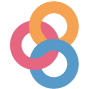)](https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath=/__w/python-datascientist/python-datascientist/notebooks/course/NLP/03_lda.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/NLP/03_lda.ipynb)



Cette page approfondit continue les exercices présentés dans la 
[section précédente](#nlpexo). 
On va ainsi continuer notre exploration de la littérature anglophones:

* Edgar Allan Poe, (EAP) ;
* HP Lovecraft (HPL) ;
* Mary Wollstonecraft Shelley (MWS).

Les données sont disponibles ici : [spooky.csv](https://github.com/GU4243-ADS/spring2018-project1-ginnyqg/blob/master/data/spooky.csv) et peuvent être requétées via l'url 
<https://github.com/GU4243-ADS/spring2018-project1-ginnyqg/raw/master/data/spooky.csv>.

Le but va être dans un premier temps de regarder dans le détail les termes les plus fréquents utilisés par les auteurs, de les représenter graphiquement puis on va ensuite essayer de prédire quel texte correspond à quel auteur à partir d'un modèle `Word2Vec`.

Ce notebook librement inspiré de  : 

* https://www.kaggle.com/enerrio/scary-nlp-with-spacy-and-keras
* https://github.com/GU4243-ADS/spring2018-project1-ginnyqg
* https://www.kaggle.com/meiyizi/spooky-nlp-and-topic-modelling-tutorial/notebook

## Librairies nécessaires

Cette page évoquera, les principales librairies pour faire du NLP, notamment: 

* [WordCloud](https://github.com/amueller/word_cloud)
* [nltk](https://www.nltk.org/)
* [spacy](https://spacy.io/)
* [Keras](https://keras.io/)
* [TensorFlow](https://www.tensorflow.org/)

Comme dans la [partie précédente](#nlpexo), il faut télécharger quelques
éléments pour que `NTLK` puisse fonctionner correctement. Pour cela, faire:

~~~python
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('genesis')
nltk.download('wordnet')
~~~

La liste des modules à importer est assez longue, la voici:


## Données utilisées

*Si vous avez déjà lu la section précédente et importé les données, vous
pouvez passer à la section suivante*

Le code suivant permet d'importer le jeu de données `spooky`: 

In [ ]:
import pandas as pd

url='https://github.com/GU4243-ADS/spring2018-project1-ginnyqg/raw/master/data/spooky.csv'
import pandas as pd
train = pd.read_csv(url,
                    encoding='latin-1')
train.columns = train.columns.str.capitalize()
                    
train['ID'] = train['Id'].str.replace("id","")
train = train.set_index('Id')

Le jeu de données met ainsi en regard un auteur avec une phrase qu'il a écrite:

```
##                                                       Text Author     ID
## Id                                                                      
## id26305  This process, however, afforded me no means of...    EAP  26305
## id17569  It never once occurred to me that the fumbling...    HPL  17569
## id11008  In his left hand was a gold snuff box, from wh...    EAP  11008
## id27763  How lovely is spring As we looked from Windsor...    MWS  27763
## id12958  Finding nothing else, not even gold, the Super...    HPL  12958
```

Les étapes de *preprocessing* sont expliquées au [chapitre précédent](#nlpexo). On applique les étapes suivantes:

1. Tokeniser
2. Retirer la ponctuation et les stopwords
3. Lemmatiser le texte

```
##       ID Author                                          tokenized
## 0  00001    MWS              [Idris, well, content, resolve, mine]
## 1  00002    HPL  [I, faint, even, fainter, hateful, modernity, ...
```


## Principe de la LDA (Latent Dirichlet Allocation)

Le modèle Latent Dirichlet Allocation (LDA) est un modèle probabiliste génératif qui permet
de décrire des collections de documents de texte ou d’autres types de données discrètes. LDA fait
partie d’une catégorie de modèles appelés “topic models”, qui cherchent à découvrir des structures
thématiques cachées dans des vastes archives de documents.

Ceci permet d’obtenir des méthodes
efficaces pour le traitement et l’organisation des documents de ces archives: organisation automatique
des documents par sujet, recherche, compréhension et analyse du texte, ou même résumer des
textes. 

Aujourd’hui, ce genre de méthodes s’utilisent fréquemment dans le web, par exemple pour
analyser des ensemble d’articles d’actualité, les regrouper par sujet, faire de la recommendation
d’articles, etc. 

LDA assumes documents are produced from a mixture of topics. Those topics then generate words based on their probability distribution. Given a dataset of documents, LDA backtracks and tries to figure out what topics would create those documents in the first place.

La LDA est une méthode qui considère les corpus comme des mélanges de sujets et
de mots. Chaque document peut être représenté comme le résutlat d'un mélange
de sujets et, au sein de ces sujets, d'un choix de mots. L’estimation des
paramètres de la LDA passe par l’estimation des distributions des variables
latentes à partir des données observées (*posterior inference*). 
Mathématiquement, on peut se représenter la LDA comme une 
technique de maximisation de log vraisemblance avec un algorithme EM
dans un modèle de mélange.

La matrice termes-documents qui sert de point de départ est la suivante:

|     | word_1 | word_2 | word_3 | ... | word_J |
|---- |--------|--------|--------|-----|--------|
|doc_1| 3      | 0      | 1      | ... | 0      |
| ... | ...    | ...    | ...    | ... | ...    |
|doc_N| 1      | 0      | 0      | ... | 5      |

La LDA consiste à transformer cette matrice *sparse*
(creuse en Français) document-terme en deux matrices de moindre dimension:

1. Une matrice document-sujet
2. Une matrice sujet-mots

En notant $K_i$ le sujet $i$. On obtient donc

* Une matrice document-sujet ayant la structure suivante:

|     | K_1 | K_2 | K_3 | ... | K_M |
|---- |--------|--------|--------|-----|--------|
|doc_1| 1      | 0      | 1      | ... | 0      |
| ... | ...    | ...    | ...    | ... | ...    |
|doc_N| 1      | 1      | 1      | ... | 0      |

* Une matrice sujets-mots ayant la structure suivante:

|     | word_1 | word_2 | word_3 | ... | word_J |
|---- |--------|--------|--------|-----|--------|
|K_1| 1      | 0      | 0      | ... | 0      |
| ... | ...    | ...    | ...    | ... | ...    |
|K_M| 1      | 1      | 1      | ... | 0      |

Ces deux matrices ont l'interprétation suivante :

* La première nous renseigne sur la présence d'un sujet dans un document
* La seconde nous renseigne sur la présence d'un mot dans un sujet

En fait, le principe de la LDA est de construire ces deux matrices à partir des fréquences d'apparition des mots dans le texte. 


On va se concentrer sur Edgar Allan Poe. 

**Détails à venir**





```
## LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
##                           max_iter=5, n_components=11, n_jobs=1,
##                           random_state=0)
```

```
## Topics found via LDA:
```

```
## 
## Topic #0:
## arm looking thousand respect hour table woman rest ah seen
## 
## Topic #1:
## said dupin ha end write smith chair phenomenon quite john
## 
## Topic #2:
## time thing say body matter course day place object immediately
## 
## Topic #3:
## mere memory felt sat movement case sole green principle bone
## 
## Topic #4:
## door room open small friend lady replied night window hand
## 
## Topic #5:
## word man day idea good point house shall mind say
## 
## Topic #6:
## eye figure form left sea hour ordinary life deep world
## 
## Topic #7:
## foot great little earth let le year nature come nearly
## 
## Topic #8:
## hand strange head color hair spoken read ear ghastly neck
## 
## Topic #9:
## came looked shadow low dream like death light spirit tree
## 
## Topic #10:
## eye know heart saw character far tell oh voice wall
```


In [ ]:
import pyLDAvis
import pyLDAvis.sklearn

# pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, count_data, count_vectorizer, n_jobs = 1)

```
## /opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
##   from imp import reload
```

```
## '\n<link rel="stylesheet" type="text/css" href="https://cdn.jsdelivr.net/gh/bmabey/pyLDAvis@3.3.1/pyLDAvis/js/ldavis.v1.0.0.css">\n\n\n<div id="ldavis_el559140364773221984925691288"></div>\n<script type="text/javascript">\n\nvar ldavis_el559140364773221984925691288_data = {"mdsDat": {"x": [0.22997986654376695, 0.21575456063709608, 0.1499390460806675, -0.0132116505507256, -0.003097137883954287, -0.04003664138758001, -0.10397906156943486, -0.10671848939738458, -0.1057364470149015, -0.10416751874631434, -0.11872652671123426], "y": [-0.03025406845296497, -0.10160957954546743, 0.10032751215253355, 0.2196910333567761, 0.10996111106055492, -0.22688024884839914, 0.03556052606080631, -0.011783547632418626, -0.014034733346005565, -0.045409982118236505, -0.03556802268717906], "topics": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], "cluster": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], "Freq": [20.499398170691858, 18.638194347963992, 13.691602068870054, 9.691393696960045, 8.76628621929609, 7.318475810226449, 6.0216500635933645, 4.067736530247875, 3.9983841823663333, 3.9293704092918267, 3.3775085004921177]}, "tinfo": {"Term": ["said", "eye", "door", "room", "thing", "time", "word", "hand", "foot", "came", "arm", "know", "heart", "say", "body", "far", "open", "hour", "thousand", "character", "saw", "matter", "small", "head", "great", "mere", "idea", "earth", "left", "man", "word", "idea", "circumstance", "effect", "machine", "design", "necessary", "observation", "better", "entered", "piece", "automaton", "sir", "motion", "tone", "business", "example", "return", "immediate", "month", "public", "occurred", "lie", "absolutely", "genius", "satisfied", "ago", "unusual", "remain", "usually", "home", "sufficiently", "believe", "house", "good", "certain", "result", "shall", "singular", "view", "man", "mind", "point", "purpose", "day", "fact", "old", "way", "thought", "possible", "far", "say", "little", "said", "seen", "doubt", "let", "second", "immediately", "madame", "knew", "kind", "speak", "discovered", "fully", "remained", "evidence", "car", "breath", "people", "boat", "cut", "east", "carefully", "properly", "bob", "reply", "editor", "remote", "fool", "sunday", "upper", "getting", "failed", "page", "body", "content", "thing", "corpse", "place", "matter", "mouth", "reason", "course", "question", "object", "time", "book", "lay", "say", "marie", "observed", "appeared", "day", "long", "length", "make", "hand", "thought", "point", "foot", "earth", "horror", "god", "terror", "come", "inch", "apparent", "fellow", "height", "received", "pain", "angle", "apparently", "consequence", "captain", "measure", "committed", "blood", "visible", "smile", "elevation", "hitherto", "sum", "admitted", "diameter", "conceive", "rise", "past", "officer", "distance", "interval", "surface", "extreme", "reached", "great", "degree", "moon", "cause", "let", "le", "year", "nature", "nearly", "little", "air", "known", "death", "make", "minute", "life", "person", "length", "way", "figure", "sea", "ordinary", "deep", "mile", "bear", "dat", "skull", "fallen", "big", "master", "forever", "note", "buried", "gentle", "palace", "fate", "summit", "gazed", "valley", "image", "drapery", "throw", "thou", "save", "fearful", "series", "forehead", "witness", "servant", "real", "form", "sentiment", "art", "grew", "silence", "eye", "half", "world", "left", "hour", "life", "scene", "face", "sure", "terrible", "voice", "turn", "hope", "like", "time", "black", "vision", "mind", "wild", "wall", "thought", "long", "know", "heart", "tell", "oh", "yes", "floor", "family", "set", "succeeded", "teeth", "danger", "loud", "study", "fortune", "mistaken", "run", "happened", "excellent", "shriek", "ready", "ligeia", "rigid", "served", "caused", "female", "staircase", "abyss", "noble", "illustrious", "rate", "loss", "caught", "love", "saw", "ceased", "bore", "character", "number", "eye", "wall", "human", "expression", "far", "voice", "heard", "care", "fell", "perceive", "look", "moment", "countenance", "man", "felt", "like", "went", "door", "small", "replied", "apartment", "evidently", "room", "iron", "rue", "prefect", "compartment", "confess", "different", "writer", "wilson", "got", "diddle", "sitting", "rear", "escaped", "disorder", "engaged", "taste", "coast", "cupboard", "pound", "society", "firm", "lid", "assassin", "seemingly", "drawer", "open", "window", "close", "main", "cat", "seat", "friend", "lady", "drawing", "box", "diddler", "et", "rapid", "night", "hand", "step", "brought", "chamber", "large", "head", "mean", "saw", "looked", "shadow", "low", "dream", "red", "frame", "intense", "agony", "tall", "sensation", "excitement", "flower", "passion", "watch", "behold", "artificial", "recess", "channel", "singularly", "melancholy", "dying", "creation", "hard", "approaching", "lead", "victim", "wilderness", "usher", "carpet", "forest", "came", "wonder", "feeling", "spirit", "tree", "arose", "bed", "sound", "death", "light", "beautiful", "like", "water", "seen", "length", "looking", "respect", "woman", "rest", "ah", "grace", "increased", "wyatt", "pompey", "naturally", "te", "fastened", "personage", "regular", "hint", "kempelen", "price", "maillard", "arm", "psyche", "mille", "deceived", "talk", "zenobia", "entitled", "shudder", "worse", "smiled", "diana", "remedy", "sister", "table", "leg", "thousand", "bell", "help", "von", "monsieur", "hour", "street", "seen", "right", "little", "left", "beauty", "memory", "sat", "movement", "sole", "green", "bone", "readily", "accomplished", "following", "prodigious", "ocean", "wrong", "admit", "crowded", "absorbed", "vivid", "bottle", "bag", "originally", "beginning", "partially", "plainly", "disturbance", "wore", "wit", "introduction", "louder", "interested", "suffering", "represented", "weight", "met", "mere", "felt", "principle", "case", "imagination", "rich", "moment", "simple", "ha", "write", "smith", "dupin", "phenomenon", "understanding", "massa", "crab", "assured", "exercise", "free", "quietly", "resumed", "convinced", "nerve", "chief", "undoubtedly", "john", "hu", "ca", "calling", "blind", "seventh", "miss", "amusement", "wrote", "touched", "susceptible", "vibration", "thomas", "said", "la", "chair", "end", "quite", "struggled", "excessively", "legrand", "strange", "color", "spoken", "read", "ghastly", "lived", "sudden", "paused", "excessive", "ugh", "seek", "yxu", "dragged", "outline", "comprehension", "fast", "crimson", "shook", "mortal", "ringing", "dx", "traced", "listen", "plume", "laugh", "dungeon", "gx", "luminous", "ottoman", "flowing", "neck", "hair", "mountain", "observe", "mystery", "hand", "ear", "head", "instant", "thing", "took"], "Freq": [293.0, 236.0, 122.0, 115.0, 195.0, 263.0, 172.0, 149.0, 131.0, 109.0, 78.0, 99.0, 95.0, 284.0, 140.0, 135.0, 84.0, 104.0, 79.0, 110.0, 101.0, 142.0, 72.0, 148.0, 202.0, 71.0, 118.0, 92.0, 121.0, 222.0, 172.10433583473164, 117.29716275428515, 70.84577055174695, 60.23796191962823, 57.04270298021049, 54.932391827913236, 49.10958368465201, 46.435914517003795, 45.782898966992704, 45.97319656600162, 45.59549377306763, 43.92758646659655, 40.41622609335469, 42.154112469957596, 40.09266436373468, 39.26653287327785, 38.521971529312744, 37.40651921577504, 37.365244712623756, 35.58527070357543, 33.20591455163077, 31.690661226719936, 31.502049719298046, 28.978283017843086, 28.835987041364397, 28.562451688162884, 28.51626390477374, 27.113374268079454, 25.921522017213746, 27.41511731063869, 52.90754166395032, 42.49398703669264, 47.394759063446365, 90.41713035274232, 109.69390943448113, 61.982558807148536, 54.518580641694086, 89.2293375512492, 43.260644329775474, 57.70742610846202, 141.58456898629646, 89.19706042160597, 101.21914639411172, 57.815711224895765, 133.82427171745357, 76.29356966501756, 76.25616659096941, 81.64935009129103, 84.36279936179248, 54.66834137235476, 72.69649756544429, 85.90783231969758, 79.22885161146019, 81.24682922736079, 51.859782013689916, 50.407043807260045, 50.74984205251539, 77.40840256372717, 81.21102178207519, 62.82664669201367, 58.46933342727409, 54.91278694618889, 51.098563088914815, 49.62460131857126, 48.940514823187065, 47.54747915382271, 41.87488670703669, 41.03534025513118, 39.95903045955082, 39.537975042141376, 40.031701396080585, 34.69897201856249, 30.631869288847643, 29.160882074157616, 28.470991694198243, 27.43823165396508, 26.04960696968305, 25.331932228925822, 23.992557368453205, 22.271004272668797, 22.433042055721767, 22.43025834186166, 21.76237622672828, 21.386692542343617, 21.306305877833953, 135.53988295757878, 19.587270479202093, 182.4305956514431, 56.83618827151922, 89.60280597907, 129.26136018468407, 45.35645072610822, 73.2093744048457, 101.95663347924956, 77.50900652407896, 82.87946200974164, 195.87740473645553, 44.9891323752707, 66.08306600689717, 174.4415841478069, 38.81946292903936, 47.39343658363017, 55.04459871275544, 90.65018963091268, 79.78974590119125, 66.85787368883882, 54.56336557117954, 53.90177690138315, 52.001856983160614, 51.30807585086025, 130.63467109088052, 91.6927320510452, 55.91882370345013, 56.07429099206399, 47.12253795541031, 57.7255029661571, 41.58970384562945, 40.0126372760849, 38.09974946069101, 37.80916355573584, 37.0979777920068, 35.5712051905967, 38.56667043129446, 33.32636674559212, 33.59600274966244, 31.558829521723684, 30.41514826818177, 27.197698425060654, 26.975530617321898, 26.277339281319517, 25.240713646638515, 24.563061197241574, 23.381757282607776, 23.23578037569888, 20.394229757673838, 19.269797901641947, 18.834720784851726, 18.015184067063863, 17.538965761981682, 17.43523113349796, 42.89218503303501, 34.22887710081935, 50.93476056123597, 31.07323479793603, 27.63630226281464, 122.17405569177699, 54.58371329957114, 43.17559424454399, 35.41930239073477, 78.71824470580204, 77.32825928309468, 65.72863285646888, 60.34048801252338, 56.759730142651755, 99.61693086111694, 55.98241938887283, 43.675825483192995, 48.741587493474455, 53.18633884924788, 49.191808755102706, 49.408900309238796, 51.31920545369707, 52.978411227769676, 40.31913773803813, 66.93875572361138, 61.6062344884284, 56.18591617993899, 52.589861981835725, 36.56229581918726, 26.50987855960969, 25.745472149947766, 23.418594374824583, 23.0748867492517, 22.740706532944127, 22.74961665051863, 21.355084772133008, 20.685495509076453, 20.604561519295476, 20.42848617873675, 19.81037422727353, 19.653655936636483, 19.35866471073198, 18.946731880286325, 19.5189687848133, 18.894520511470617, 18.359922617682845, 17.885022483278068, 23.092038755491814, 20.519461778827218, 17.581017517418655, 18.112348635871093, 16.009745254329044, 15.114172008073982, 15.213186879436543, 28.40035733686288, 65.80849276616317, 35.71491533133901, 37.95231517541355, 39.76733603290301, 20.59471937432172, 114.92690378840746, 50.82912079874431, 50.9808521964304, 62.97642625080224, 56.60724644706644, 54.63251914747764, 29.778476501651735, 38.14869878435862, 42.24997152080456, 26.517246818150532, 42.217172155895824, 26.238782742660344, 28.608785412741277, 41.64767331623409, 47.99236370170884, 28.48080071084543, 26.70412401265397, 33.30147628887881, 27.696609739699348, 28.80027877390606, 29.57131734947686, 26.956508804490372, 98.9643981168507, 94.27941474574494, 55.28031412018633, 51.56953010400556, 42.44964697279878, 41.85582090965823, 37.492631083753686, 45.91953404470037, 30.098670487023302, 26.98251931648321, 23.06036243375136, 22.336528535770682, 20.658916360192045, 19.618100639841398, 19.200536661912004, 18.93463863162459, 17.644034319833363, 16.12218915387038, 15.977391266289313, 15.675463325421672, 15.582246921725101, 14.77465914011368, 14.503095602319242, 14.438183828606626, 14.070623457994943, 13.801863424259055, 13.446726699423055, 13.124697147431798, 13.172869404628065, 12.612952870946991, 15.19236448011502, 15.38404648452791, 39.715879223511415, 78.05444463928579, 18.480946795399117, 22.54987131278099, 74.46704986071575, 31.243027805558462, 120.94109252745734, 46.596638174549255, 43.207602942432175, 34.19774022248531, 62.2315334286718, 49.17864984192713, 40.2049921543876, 21.668367806806174, 31.944994219604787, 27.869720970104936, 27.65621310414833, 34.386588241946505, 26.157281984416652, 40.63098223755032, 28.013664768421798, 31.296242018178607, 26.117558685405136, 122.141376297302, 71.5765077405076, 47.37982294710013, 40.26211664143405, 29.112271219578755, 112.22053729152854, 25.80641553624512, 24.93319921724273, 23.629970372999818, 22.97808042666251, 20.32897161646579, 19.968499551912366, 19.852230200043376, 17.798743613960077, 17.59870650119774, 17.209326640547136, 16.883371075048498, 16.17778265400929, 15.833173216490952, 15.8610372494618, 15.806898061761682, 14.688599573761698, 14.6398724453954, 14.970262481850305, 13.342544115338338, 13.270091715061792, 12.807978730144788, 12.413262576850032, 11.917812321932232, 11.721090801208632, 31.472218084043664, 74.88920705849092, 45.335215867831835, 34.769749675135145, 41.229124089429895, 20.188291427060904, 20.420725127433492, 57.21277248459988, 51.985501748273236, 22.35501624537824, 34.53026592494012, 18.91709096360063, 18.78958415720705, 19.48628253530104, 45.85211925110092, 44.056581502696424, 28.78938931571168, 27.429477776255805, 28.300418824706004, 29.222980474494733, 32.04851071422044, 25.020765505091564, 22.6569830916139, 54.02178860346412, 53.53930060455354, 47.51289811849033, 47.26291869598632, 31.581705403679507, 25.21656984510743, 28.210943968691485, 22.748121937411607, 22.256899524081078, 21.583277188836366, 20.768790957985733, 21.34939435618877, 19.663040915831665, 18.729990807403485, 15.866508281977334, 15.677667643633669, 15.698036280917833, 15.240429905743358, 14.95737568170479, 14.412309413157695, 14.259238590724141, 13.342280872345622, 13.136602559879181, 13.541336943827465, 12.864185041755379, 12.835011925934632, 12.53058958050478, 12.417617708269054, 12.165130533252528, 11.930246213222263, 76.91628623421536, 27.361869557832428, 32.01992503845581, 40.237411521721185, 35.74201566437017, 28.288498650202836, 29.68297383834294, 31.850280915236, 43.10710849345567, 41.69941782057683, 22.133476585884036, 45.0781032817847, 33.77873072994994, 18.79729084880834, 16.59942754861326, 51.74562633619878, 39.070283254284114, 30.28374049084133, 26.858714483231676, 24.768577447023045, 21.085300864882477, 18.965379436537347, 18.903550087221266, 18.640079767662463, 18.526062693961862, 15.107365835753479, 12.98889880316876, 12.768047968077887, 12.435358476877642, 11.484644019852961, 11.247934721588173, 9.922519759170639, 9.936697054509347, 72.97335400124234, 9.59801089993163, 9.31544166316608, 9.229340979417545, 8.8701462386251, 8.834464850282208, 8.470429262438971, 8.392993832056225, 8.232978972302627, 7.969628914916037, 7.533931906688493, 7.467289713660369, 8.012915759167237, 32.332804764291524, 15.069212013066393, 49.36119247841245, 13.379824061085687, 15.826127065804036, 16.540018504835317, 20.11741517025279, 34.979176889169764, 18.53480191721764, 24.06203342481081, 21.559256978149865, 17.18214523773475, 14.957938794577315, 11.269033454577894, 38.39344246565532, 35.21425331227403, 33.84530949942672, 29.04755282298446, 24.290646277664784, 22.37281622656629, 22.27638425480856, 19.24689633306005, 19.2005123466224, 18.603057530031624, 15.320763179683722, 14.961723761739362, 14.17873766935054, 13.749687812815104, 13.44291061012321, 13.065211604594362, 12.839203104279633, 13.20646723685885, 12.312862558380644, 12.29482885042828, 12.227024614256305, 12.142725518849716, 11.62603535282846, 10.867624550470069, 10.688057176401465, 10.577446213454772, 9.702796494532262, 9.59382525387592, 9.23280857687683, 9.2089912627745, 22.216205929779694, 17.16580673070678, 40.14695453405061, 37.2141443928989, 23.166892509782574, 30.331208012455797, 13.476449519585833, 13.170898822902124, 15.955405579489335, 12.265284285358305, 26.765979938965476, 22.888554862735077, 21.680474933703014, 41.71446752477999, 17.27023151015558, 16.150374529472668, 15.351786811416448, 14.207001222570605, 14.00723207758532, 13.741042760029362, 13.240050047573584, 12.797495191792603, 12.62156084951411, 11.83487084040418, 11.419019765369724, 11.352437774444187, 11.340439569734741, 16.31463571681353, 10.567864599484354, 10.483374783171275, 9.818593983261026, 9.723782369855007, 9.629116210137083, 9.469848712880909, 9.381761436095829, 10.789213340750191, 8.575990478605293, 8.5306675000789, 8.408161491219438, 8.30194922702165, 211.32975981781846, 13.367613515258302, 17.3494560086145, 26.377672899897018, 16.703121197055477, 10.3927926439688, 9.69762155153489, 9.701757770318357, 32.711424411393466, 24.90032172709336, 20.461649209373682, 19.77354501428003, 19.605457268291296, 14.167139194731543, 13.99387201898636, 13.647935426323377, 12.976117170211266, 13.128728383813302, 12.18452971847026, 10.543835808377246, 10.010730662275211, 9.205829926537298, 9.01873471213098, 8.865408904293231, 8.662174812721544, 8.133469523473465, 8.116823881308907, 7.359318455200144, 6.9598649990726, 6.611875351614407, 6.535511851206794, 6.5566477857190755, 6.5120120830758434, 6.440121588835149, 6.313167957294493, 6.1928686949985705, 6.1693965618977735, 6.076190730587839, 16.611344451815636, 22.795293283822968, 13.766747828895861, 11.51393227272799, 15.914757792592747, 38.615096040019374, 19.74324695448522, 27.57736638393307, 9.220795853085432, 11.482190532264076, 7.474820910815221], "Total": [293.0, 236.0, 122.0, 115.0, 195.0, 263.0, 172.0, 149.0, 131.0, 109.0, 78.0, 99.0, 95.0, 284.0, 140.0, 135.0, 84.0, 104.0, 79.0, 110.0, 101.0, 142.0, 72.0, 148.0, 202.0, 71.0, 118.0, 92.0, 121.0, 222.0, 172.86301924354655, 118.05805314849482, 71.60246166186747, 60.99501540354527, 57.7994548988496, 55.6916627724818, 49.868103260544935, 47.19494122021409, 46.54306216513624, 46.73982363229959, 46.35637970609267, 44.686340696824466, 41.17212203386672, 42.94393454492317, 40.849240300203256, 40.02367524117572, 39.28136833704922, 38.16334344401719, 38.121894774913756, 36.35148050730855, 33.99001933048605, 32.44702005270278, 32.260870579167545, 29.735468096994886, 29.592586476454596, 29.31989932722464, 29.27990301878971, 27.873054455265446, 26.678182938458704, 28.216256121247923, 55.034594114752025, 44.2305107418579, 49.622877496330815, 100.97069839550858, 127.07046515455062, 69.26947466348551, 62.305990643926805, 118.28707757622885, 48.02555674415343, 69.27142253667448, 222.0515439264446, 123.47650793400268, 153.4817195171455, 70.41453162754709, 231.79366637737724, 112.41861290652335, 119.4778896490072, 140.2104552291972, 170.8941245720677, 73.05552063825793, 135.74236051524545, 284.9963470068146, 239.140904008474, 293.56089088474806, 106.6400603638725, 96.31163825480495, 131.0352490998233, 78.16585446171138, 82.03965738672194, 63.584254753131134, 59.22618510883233, 55.68102280511046, 51.85536069639177, 50.38198576412571, 49.70144306671884, 48.31828726128801, 42.633555342570524, 41.79628627753292, 40.72382347280274, 40.29536369868358, 40.81207997670662, 35.4566077426968, 31.390599640108793, 29.917570547065743, 29.288223172464658, 28.22935908090204, 26.80623180545607, 26.088199243788182, 24.752567359958537, 23.027962963955737, 23.19560753965397, 23.209385045198985, 22.520689448773417, 22.144265289023846, 22.069378410528493, 140.43885370969974, 20.34401492555678, 195.89296333191513, 60.000458855416525, 95.62818153910564, 142.0880487058846, 48.51507928449723, 80.55413804024933, 115.80048867162165, 88.74375839123155, 97.09226624221418, 263.5963318913645, 50.10261250507426, 81.18832373568722, 284.9963470068146, 43.40737003013087, 57.53990798325996, 73.44542264722868, 231.79366637737724, 189.61380858578053, 145.00296329361058, 126.47651342423399, 149.1185047896694, 170.8941245720677, 153.4817195171455, 131.3963382452355, 92.5572527487454, 56.67838939339869, 56.8420323676448, 47.89066464880349, 58.67340234042872, 42.34988507747051, 40.772526992369805, 38.85823612705768, 38.574585642964664, 37.85575190882234, 36.32920568922737, 39.46468318040587, 34.10620108493802, 34.3839306625094, 32.31902965289203, 31.17292104571205, 27.95626326983753, 27.733280704462466, 27.037031292569484, 26.000537328483084, 25.320273547371198, 24.143742792569288, 23.995358358452037, 21.154288783696877, 20.028104381995675, 19.594254349615156, 18.772895624012765, 18.296385260604367, 18.192402753471, 46.81823090860957, 37.00512568342457, 59.18798079615925, 34.6144679971435, 30.61668241413196, 202.55403975611182, 75.52009386586614, 55.634074880253756, 42.52118403753492, 131.0352490998233, 134.1227910458583, 111.40426027786388, 98.1129184986941, 90.66270137440252, 239.140904008474, 93.98760693085977, 72.09247075948883, 98.78671898174532, 126.47651342423399, 102.57973930381617, 106.61442420490441, 126.82084623409375, 145.00296329361058, 140.2104552291972, 67.70088424112315, 62.369452228250175, 56.95397076557051, 53.378379864183565, 37.33052469040333, 27.272639751146105, 26.504425091728397, 24.177711274974417, 23.83397196939624, 23.506727668717005, 23.567051674580362, 22.123049455259924, 21.44661662415347, 21.36386229605422, 21.190391599087043, 20.57482273291271, 20.412394193976613, 20.121012784349855, 19.706277251564494, 20.301464750951386, 19.653686829473973, 19.118832877038408, 18.644103365613162, 24.081790355651655, 21.400333893340374, 18.341873976561047, 18.90114702711671, 16.769951452479244, 15.87349870817385, 15.991182527741987, 30.354261185361597, 75.77603758769608, 39.92632582998902, 42.6961677692388, 49.19328717898339, 22.144790867932628, 236.55260673336556, 81.28508018260491, 83.59815428883242, 121.71208696469986, 104.03534221630578, 106.61442420490441, 41.208030115452395, 63.644423304888186, 82.06417595061149, 34.537888095677324, 95.15711604257001, 35.995817365230806, 44.40590440815058, 148.62498829419746, 263.5963318913645, 51.29336348947626, 43.79347303053991, 123.47650793400268, 54.93208583557921, 76.0925532424383, 170.8941245720677, 189.61380858578053, 99.72670871277073, 95.04073599743334, 56.03975627943554, 52.33327803569851, 43.208202888626055, 42.61635517714968, 38.252926617645834, 46.88474934250551, 30.863928300686656, 27.747160814189815, 23.8190714875359, 23.09513676368227, 21.42156599934335, 20.377079670111655, 19.959110140131973, 19.693783273021356, 18.44261142802795, 16.881175821288135, 16.740070440078984, 16.43659862942789, 16.345025852708496, 15.533198389656041, 15.262791865752162, 15.200083323664588, 14.830527459385655, 14.562937194767265, 14.206605338866732, 13.885297220464768, 13.93671760919451, 13.372560372171714, 16.1516752522371, 16.38467244604899, 46.664082323891, 101.39438188461264, 20.26578607894555, 26.134414084077843, 110.45166665803164, 39.54948583171133, 236.55260673336556, 76.0925532424383, 69.06143324533821, 53.167273384269656, 135.74236051524545, 95.15711604257001, 75.01973694232618, 27.763398517859166, 63.82249756622317, 48.35292562856739, 51.17179034705344, 105.42063984922497, 48.19261934233024, 222.0515439264446, 81.50295463361404, 148.62498829419746, 61.26527041251776, 122.90293971475269, 72.35520158735746, 48.14081740416587, 41.02277449996262, 29.873055115152532, 115.34383480070784, 26.568131172182152, 25.69592043130935, 24.398789174381555, 23.757685555130067, 21.094124526592438, 20.7303940004627, 20.61602748807033, 18.559798054245405, 18.36485548017491, 17.96964972917004, 17.648628003845864, 16.938991447235296, 16.593933254027515, 16.623509802645863, 16.567970132393324, 15.452445233525902, 15.403022706403801, 15.762442400218058, 14.106828550822444, 14.030556530851262, 13.575273978922732, 13.17384199599648, 12.678529769099029, 12.486071270962853, 34.44136004694288, 84.64375161535295, 56.658750523639775, 41.94645493169741, 51.11708701144974, 23.138443612262055, 23.723695564827324, 91.7451659131419, 82.05248478343182, 27.839380620446754, 54.695925949001165, 22.182950775437536, 22.46241456977132, 24.060786803901024, 132.76953321973448, 149.1185047896694, 58.137543156200195, 53.90663602617385, 73.82208719524685, 86.95327838385631, 148.0830290775615, 139.87934037916256, 101.39438188461264, 54.783858696358266, 54.37545599136123, 48.27608252238448, 48.025715315030155, 32.34532908507126, 25.97736121114844, 29.066586387488616, 23.521036374835365, 23.01810519994651, 22.344722200215493, 21.532971140717994, 22.160668647576294, 20.42491287611903, 19.49085921751748, 16.627315457979513, 16.440079606429325, 16.462767469818143, 16.007050904347885, 15.718952585400576, 15.173363400631873, 15.023119502704175, 14.103306955302868, 13.897763482884324, 14.331846197659196, 13.62513413415158, 13.596253811682326, 13.291669360812831, 13.179035387587454, 12.928623916669078, 12.69077112848255, 109.72570361459354, 34.76306669442959, 46.131434332614326, 71.8366258746232, 61.564468550928844, 44.68943773339257, 48.35547322717921, 55.075800523969136, 98.78671898174532, 95.68081308044957, 34.2543428470096, 148.62498829419746, 108.73428743742261, 106.6400603638725, 145.00296329361058, 52.514298168244856, 39.83580588780397, 31.04939080052996, 27.625075891087803, 25.5364400713121, 21.850739171513936, 19.731477710751996, 19.669941555831077, 19.405314405782267, 19.30689369656929, 15.874442899528836, 13.758404403038277, 13.535710694837586, 13.208949179987638, 12.249864317714996, 12.013351934534949, 10.688136729436579, 10.705519349767016, 78.66643752721558, 10.364372376712813, 10.080249957351826, 9.994643439836183, 9.635717646269851, 9.600422499855195, 9.235658339342432, 9.15912748852991, 9.002003065887187, 8.739338957221035, 8.299392033943896, 8.233495987906801, 8.876417607497475, 43.87100586042742, 18.855261907934658, 79.14454724609202, 16.798882167994385, 21.623758585702575, 23.165465569219627, 35.23636549056518, 104.03534221630578, 38.88235542155341, 106.6400603638725, 81.57367531585047, 239.140904008474, 121.71208696469986, 41.082508468705875, 39.159004094260084, 35.9821588118486, 34.61168324893965, 29.82065627139155, 25.056873981328962, 23.13840096525776, 23.044039886084807, 20.0127191882555, 19.9682741823727, 19.368621559384113, 16.08590667076914, 15.73255349118423, 14.943719197429013, 14.516084146636937, 14.208190833821748, 13.83474642099667, 13.604757145663413, 13.998714842732742, 13.07876985152056, 13.06154963095684, 12.996965696826528, 12.912659986537472, 12.396154615867525, 11.63280280234008, 11.454830077320917, 11.342463101807889, 10.478453361786647, 10.386615905673507, 9.997705557068025, 9.97391037009383, 25.791232368531688, 21.77679446254157, 71.26722162762634, 81.50295463361404, 42.552406605975506, 83.67866616864428, 27.901976587459757, 25.95402864841082, 105.42063984922497, 31.286532870620608, 27.539864724128876, 23.676837958842754, 22.446610739919468, 43.398478591032166, 18.036511098888184, 16.918017483558316, 16.11874831107594, 14.973032753644025, 14.773575674594394, 14.507608203722283, 14.013049500273803, 13.565484067759725, 13.387720621424593, 12.601347259029057, 12.191233504167636, 12.120637296636213, 12.116975344188276, 17.49911140082098, 11.337875863852194, 11.250290463379804, 10.587869309801722, 10.49283542465825, 10.39643126246815, 10.236323521306172, 10.155458801644974, 11.684273425566614, 9.343012827335238, 9.297226384267173, 9.174419155989169, 9.068647584220779, 293.56089088474806, 16.536123962037543, 23.4512262514847, 80.97399134315687, 68.25600508501434, 15.398350205869026, 16.7736145667713, 22.240537970744654, 33.5072894823376, 25.672052380898883, 21.232372705579472, 20.54086230797548, 20.373308824615044, 14.934930108939126, 14.761840706623168, 14.415225593969152, 13.74513243835125, 13.949065212877153, 12.955742294634549, 11.310566270407225, 10.780466769991136, 9.972888183088392, 9.788087580075377, 9.633632611299316, 9.439314002360401, 8.900584408588927, 8.884047585223302, 8.128387894040415, 7.726646781719204, 7.379598540958184, 7.302682915369531, 7.327781600750629, 7.2793705945214064, 7.206991602804278, 7.0799650244891215, 6.962691453743804, 6.938938737824783, 6.845003779339286, 19.838455524866095, 32.694293261621254, 21.87732685295125, 17.20695712053625, 28.90469839457176, 149.1185047896694, 54.93899385344879, 148.0830290775615, 51.318702696583735, 195.89296333191513, 95.23349689584398], "Category": ["Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Default", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic1", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic2", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic3", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic4", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic5", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic6", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic7", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic8", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic9", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic10", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11", "Topic11"], "logprob": [30.0, 29.0, 28.0, 27.0, 26.0, 25.0, 24.0, 23.0, 22.0, 21.0, 20.0, 19.0, 18.0, 17.0, 16.0, 15.0, 14.0, 13.0, 12.0, 11.0, 10.0, 9.0, 8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0, -4.5804, -4.9637, -5.4679, -5.6302, -5.6847, -5.7224, -5.8344, -5.8904, -5.9045, -5.9004, -5.9086, -5.9459, -6.0292, -5.9871, -6.0373, -6.0581, -6.0772, -6.1066, -6.1077, -6.1565, -6.2257, -6.2724, -6.2784, -6.3619, -6.3668, -6.3764, -6.378, -6.4284, -6.4734, -6.4174, -5.7599, -5.9791, -5.8699, -5.224, -5.0308, -5.6016, -5.7299, -5.2372, -5.9612, -5.6731, -4.7756, -5.2376, -5.1112, -5.6712, -4.8319, -5.3939, -5.3944, -5.326, -5.2933, -5.7272, -5.4422, -5.2752, -5.3561, -5.331, -5.7799, -5.8083, -5.8015, -5.2842, -5.2362, -5.4929, -5.5648, -5.6275, -5.6995, -5.7288, -5.7427, -5.7715, -5.8986, -5.9188, -5.9454, -5.956, -5.9436, -6.0866, -6.2112, -6.2604, -6.2844, -6.3213, -6.3733, -6.4012, -6.4555, -6.53, -6.5227, -6.5229, -6.5531, -6.5705, -6.5743, -4.724, -6.6584, -4.4269, -5.5931, -5.1379, -4.7714, -5.8187, -5.3399, -5.0087, -5.2829, -5.2159, -4.3558, -5.8269, -5.4424, -4.4717, -5.9744, -5.7748, -5.6251, -5.1263, -5.2539, -5.4307, -5.6339, -5.6461, -5.682, -5.6954, -4.4524, -4.8064, -5.3009, -5.2982, -5.4721, -5.2691, -5.597, -5.6356, -5.6846, -5.6923, -5.7113, -5.7533, -5.6725, -5.8185, -5.8104, -5.873, -5.9099, -6.0217, -6.0299, -6.0561, -6.0964, -6.1236, -6.1729, -6.1791, -6.3096, -6.3663, -6.3891, -6.4336, -6.4604, -6.4663, -5.5662, -5.7918, -5.3943, -5.8885, -6.0057, -4.5194, -5.3251, -5.5596, -5.7576, -4.959, -4.9768, -5.1393, -5.2248, -5.286, -4.7235, -5.2998, -5.548, -5.4383, -5.351, -5.4291, -5.4247, -5.3868, -5.355, -5.628, -4.7755, -4.8585, -4.9506, -5.0168, -5.3803, -5.7018, -5.731, -5.8258, -5.8406, -5.8551, -5.8547, -5.918, -5.9499, -5.9538, -5.9624, -5.9931, -6.001, -6.0162, -6.0377, -6.0079, -6.0404, -6.0691, -6.0953, -5.8398, -5.9579, -6.1125, -6.0827, -6.2061, -6.2637, -6.2571, -5.6329, -4.7925, -5.4037, -5.343, -5.2963, -5.9543, -4.235, -5.0508, -5.0478, -4.8365, -4.9432, -4.9787, -5.5855, -5.3378, -5.2357, -5.7015, -5.2365, -5.7121, -5.6256, -5.2501, -5.1083, -5.6301, -5.6945, -5.4737, -5.658, -5.6189, -5.5925, -5.6851, -4.2842, -4.3327, -4.8666, -4.936, -5.1307, -5.1447, -5.2548, -5.0521, -5.4745, -5.5838, -5.7409, -5.7727, -5.8508, -5.9025, -5.924, -5.938, -6.0086, -6.0988, -6.1078, -6.1269, -6.1328, -6.1861, -6.2046, -6.2091, -6.2349, -6.2542, -6.2802, -6.3045, -6.3008, -6.3442, -6.1582, -6.1456, -5.1972, -4.5216, -5.9622, -5.7632, -4.5686, -5.4372, -4.0837, -5.0374, -5.113, -5.3468, -4.7481, -4.9835, -5.185, -5.8031, -5.415, -5.5514, -5.5591, -5.3413, -5.6148, -5.1744, -5.5463, -5.4355, -5.6164, -3.8933, -4.4277, -4.8403, -5.0031, -5.3273, -3.978, -5.4478, -5.4823, -5.5359, -5.5639, -5.6864, -5.7043, -5.7101, -5.8193, -5.8306, -5.853, -5.8721, -5.9148, -5.9364, -5.9346, -5.938, -6.0114, -6.0147, -5.9924, -6.1075, -6.1129, -6.1484, -6.1797, -6.2204, -6.2371, -5.2494, -4.3825, -4.8844, -5.1497, -4.9793, -5.6934, -5.6819, -4.6517, -4.7475, -5.5914, -5.1566, -5.7584, -5.7652, -5.7288, -4.873, -4.913, -5.3385, -5.3868, -5.3556, -5.3235, -5.2312, -5.4788, -5.578, -4.514, -4.523, -4.6424, -4.6477, -5.0508, -5.2759, -5.1637, -5.3789, -5.4008, -5.4315, -5.47, -5.4424, -5.5247, -5.5733, -5.7392, -5.7512, -5.7499, -5.7795, -5.7982, -5.8353, -5.846, -5.9125, -5.928, -5.8977, -5.949, -5.9512, -5.9752, -5.9843, -6.0048, -6.0243, -4.1607, -5.1943, -5.0371, -4.8086, -4.9271, -5.161, -5.1128, -5.0424, -4.7397, -4.7729, -5.4063, -4.695, -4.9836, -5.5697, -5.6941, -4.1648, -4.4458, -4.7005, -4.8206, -4.9016, -5.0626, -5.1685, -5.1718, -5.1858, -5.192, -5.396, -5.5471, -5.5642, -5.5906, -5.6701, -5.691, -5.8163, -5.8149, -3.8211, -5.8496, -5.8795, -5.8888, -5.9285, -5.9325, -5.9746, -5.9837, -6.003, -6.0355, -6.0917, -6.1006, -6.0301, -4.6351, -5.3985, -4.212, -5.5174, -5.3495, -5.3054, -5.1096, -4.5564, -5.1915, -4.9305, -5.0403, -5.2673, -5.4059, -5.6891, -4.4461, -4.5325, -4.5721, -4.725, -4.9039, -4.9861, -4.9904, -5.1366, -5.139, -5.1706, -5.3647, -5.3885, -5.4422, -5.4729, -5.4955, -5.524, -5.5414, -5.5132, -5.5833, -5.5848, -5.5903, -5.5972, -5.6407, -5.7082, -5.7248, -5.7352, -5.8215, -5.8328, -5.8712, -5.8738, -4.9931, -5.251, -4.4014, -4.4773, -4.9512, -4.6818, -5.493, -5.5159, -5.3242, -5.5872, -4.7894, -4.9459, -5.0001, -4.3457, -5.2276, -5.2946, -5.3453, -5.4228, -5.437, -5.4562, -5.4933, -5.5273, -5.5411, -5.6055, -5.6413, -5.6471, -5.6482, -5.2845, -5.7187, -5.7267, -5.7923, -5.802, -5.8117, -5.8284, -5.8378, -5.698, -5.9276, -5.9329, -5.9473, -5.96, -2.7231, -5.4837, -5.223, -4.804, -5.2609, -5.7354, -5.8047, -5.8042, -4.4375, -4.7103, -4.9066, -4.9409, -4.9494, -5.2743, -5.2866, -5.3116, -5.3621, -5.3504, -5.425, -5.5697, -5.6215, -5.7054, -5.7259, -5.743, -5.7662, -5.8292, -5.8313, -5.9292, -5.985, -6.0363, -6.0479, -6.0447, -6.0515, -6.0627, -6.0826, -6.1018, -6.1056, -6.1208, -5.1151, -4.7986, -5.3029, -5.4816, -5.158, -4.2716, -4.9424, -4.6082, -5.7037, -5.4844, -5.9137], "loglift": [30.0, 29.0, 28.0, 27.0, 26.0, 25.0, 24.0, 23.0, 22.0, 21.0, 20.0, 19.0, 18.0, 17.0, 16.0, 15.0, 14.0, 13.0, 12.0, 11.0, 10.0, 9.0, 8.0, 7.0, 6.0, 5.0, 4.0, 3.0, 2.0, 1.0, 1.5804, 1.5783, 1.5742, 1.5723, 1.5716, 1.571, 1.5694, 1.5686, 1.5683, 1.5682, 1.5682, 1.5676, 1.5662, 1.5662, 1.5661, 1.5657, 1.5653, 1.5647, 1.5647, 1.5635, 1.5614, 1.5612, 1.561, 1.559, 1.5589, 1.5586, 1.5583, 1.5571, 1.556, 1.556, 1.5454, 1.5447, 1.5388, 1.4744, 1.4377, 1.4736, 1.4513, 1.3029, 1.4803, 1.4021, 1.1348, 1.2596, 1.1685, 1.3876, 1.0355, 1.1971, 1.1357, 1.0441, 0.8789, 1.2948, 0.9603, 0.3856, 0.4801, 0.3002, 0.8639, 0.9373, 0.6362, 1.6702, 1.6698, 1.668, 1.6671, 1.6661, 1.6653, 1.6648, 1.6645, 1.6639, 1.662, 1.6616, 1.661, 1.661, 1.6607, 1.6584, 1.6555, 1.6543, 1.6517, 1.6515, 1.6513, 1.6505, 1.6488, 1.6465, 1.6465, 1.6458, 1.6457, 1.6451, 1.6448, 1.6445, 1.6421, 1.6088, 1.6258, 1.6149, 1.5853, 1.6126, 1.5844, 1.5526, 1.5446, 1.5217, 1.383, 1.5723, 1.4741, 1.1891, 1.5682, 1.486, 1.3916, 0.7411, 0.8144, 0.9058, 0.8393, 0.6624, 0.4902, 0.5842, 1.9826, 1.979, 1.9749, 1.9748, 1.9722, 1.9721, 1.9703, 1.9696, 1.9687, 1.9683, 1.9682, 1.9673, 1.9654, 1.9653, 1.9652, 1.9646, 1.9638, 1.9609, 1.9607, 1.9599, 1.9587, 1.958, 1.9563, 1.9562, 1.9518, 1.9498, 1.9489, 1.9472, 1.9461, 1.9459, 1.9008, 1.9104, 1.8382, 1.8805, 1.886, 1.4828, 1.6637, 1.7349, 1.8056, 1.4788, 1.4377, 1.4608, 1.5023, 1.5201, 1.1127, 1.4703, 1.4872, 1.282, 1.1221, 1.2535, 1.2193, 1.0837, 0.9815, 0.7421, 2.3226, 2.3216, 2.3204, 2.319, 2.3131, 2.3056, 2.3049, 2.302, 2.3016, 2.3008, 2.2986, 2.2986, 2.2978, 2.2977, 2.2973, 2.2961, 2.2961, 2.2953, 2.2946, 2.2946, 2.2945, 2.2934, 2.2924, 2.292, 2.2919, 2.2916, 2.2913, 2.2875, 2.2849, 2.2841, 2.2674, 2.1929, 2.2225, 2.2162, 2.1212, 2.2614, 1.6121, 1.8644, 1.8394, 1.675, 1.7253, 1.6653, 2.0091, 1.8221, 1.67, 2.0697, 1.5212, 2.0178, 1.8943, 1.0618, 0.6306, 1.7456, 1.8393, 1.0235, 1.6491, 1.3624, 0.5797, 0.3832, 2.4266, 2.4262, 2.4206, 2.4196, 2.4165, 2.4162, 2.4142, 2.4135, 2.4091, 2.4063, 2.4019, 2.4009, 2.398, 2.3963, 2.3955, 2.3949, 2.39, 2.3883, 2.3876, 2.3868, 2.3865, 2.3842, 2.3832, 2.3828, 2.3817, 2.3806, 2.3793, 2.3779, 2.3779, 2.3758, 2.373, 2.3712, 2.273, 2.1726, 2.3421, 2.2867, 2.04, 2.1985, 1.7634, 1.9438, 1.9653, 1.993, 1.6544, 1.7742, 1.8105, 2.1864, 1.7422, 1.8833, 1.8189, 1.314, 1.8232, 0.7359, 1.3663, 0.8763, 1.5817, 2.6086, 2.6039, 2.5988, 2.5961, 2.589, 2.5873, 2.5857, 2.5846, 2.5828, 2.5814, 2.5778, 2.5773, 2.577, 2.5729, 2.5722, 2.5715, 2.5704, 2.5688, 2.5678, 2.5678, 2.5677, 2.5641, 2.564, 2.5632, 2.5591, 2.559, 2.5566, 2.5553, 2.5529, 2.5515, 2.5246, 2.4923, 2.3918, 2.4271, 2.3998, 2.4784, 2.4648, 2.1425, 2.1584, 2.3954, 2.1548, 2.4555, 2.4362, 2.4039, 1.5516, 1.3955, 1.912, 1.9391, 1.656, 1.5244, 1.0842, 0.8937, 1.1162, 2.7958, 2.7943, 2.7939, 2.7938, 2.7859, 2.7801, 2.7799, 2.7764, 2.7762, 2.7751, 2.7737, 2.7725, 2.7718, 2.77, 2.763, 2.7623, 2.7622, 2.7607, 2.7601, 2.7584, 2.7576, 2.7543, 2.7535, 2.7531, 2.7523, 2.7522, 2.7508, 2.7503, 2.7489, 2.748, 2.4545, 2.5704, 2.4447, 2.2302, 2.2661, 2.3525, 2.3218, 2.2621, 1.9805, 1.9793, 2.3731, 1.6168, 1.6407, 1.0741, 0.6424, 3.1873, 3.1827, 3.1771, 3.1739, 3.1716, 3.1664, 3.1625, 3.1623, 3.1619, 3.1608, 3.1526, 3.1445, 3.1437, 3.1417, 3.1376, 3.1362, 3.1278, 3.1276, 3.127, 3.1253, 3.1232, 3.1224, 3.1193, 3.1189, 3.1156, 3.1147, 3.1128, 3.1099, 3.1053, 3.1044, 3.0997, 2.8969, 2.9779, 2.73, 2.9745, 2.89, 2.8652, 2.6416, 2.1121, 2.4612, 1.7133, 1.8714, 0.5689, 1.1057, 1.9086, 3.1995, 3.1977, 3.1969, 3.193, 3.1882, 3.1856, 3.1854, 3.1803, 3.1801, 3.179, 3.1705, 3.169, 3.1667, 3.165, 3.1639, 3.162, 3.1614, 3.161, 3.1589, 3.1588, 3.1582, 3.1578, 3.1551, 3.1512, 3.15, 3.1495, 3.1424, 3.1399, 3.1397, 3.1395, 3.0701, 2.9814, 2.6454, 2.4353, 2.6113, 2.2045, 2.4915, 2.541, 1.3311, 2.2829, 3.2082, 3.2028, 3.202, 3.1971, 3.1933, 3.1903, 3.1879, 3.1842, 3.1834, 3.1824, 3.1799, 3.1784, 3.1778, 3.1739, 3.1713, 3.1712, 3.1705, 3.1666, 3.1664, 3.1661, 3.1613, 3.1606, 3.16, 3.1589, 3.1574, 3.157, 3.151, 3.1506, 3.1495, 3.1484, 2.908, 3.024, 2.9353, 2.1151, 1.829, 2.8435, 2.6888, 2.4071, 3.364, 3.3575, 3.3511, 3.35, 3.3496, 3.3353, 3.3346, 3.3333, 3.3305, 3.3274, 3.3267, 3.3178, 3.314, 3.308, 3.3062, 3.3049, 3.3021, 3.2979, 3.2977, 3.2886, 3.2835, 3.2782, 3.277, 3.2768, 3.2766, 3.2755, 3.2734, 3.2709, 3.2705, 3.2689, 3.2105, 3.0274, 2.9248, 2.9863, 2.7913, 2.0369, 2.3646, 1.7073, 1.6714, 0.5513, 0.8432]}, "token.table": {"Topic": [1, 9, 5, 9, 9, 3, 1, 7, 8, 1, 3, 4, 10, 10, 3, 6, 3, 3, 2, 8, 9, 7, 5, 8, 2, 6, 7, 8, 4, 9, 10, 7, 6, 10, 1, 9, 4, 1, 7, 4, 7, 8, 6, 7, 9, 7, 1, 8, 9, 8, 11, 1, 4, 4, 5, 7, 9, 10, 3, 2, 2, 1, 2, 11, 9, 2, 4, 11, 5, 11, 9, 1, 2, 4, 6, 2, 1, 4, 6, 8, 4, 1, 10, 10, 1, 2, 5, 7, 3, 2, 5, 11, 2, 7, 2, 3, 9, 6, 8, 5, 2, 3, 5, 5, 9, 1, 2, 7, 2, 10, 2, 4, 5, 6, 11, 7, 3, 5, 10, 1, 6, 7, 6, 11, 3, 3, 6, 11, 3, 6, 3, 2, 10, 1, 2, 2, 4, 5, 10, 1, 2, 10, 7, 11, 9, 6, 2, 5, 4, 1, 2, 6, 8, 1, 3, 7, 11, 8, 4, 1, 3, 1, 3, 8, 6, 2, 6, 6, 2, 6, 3, 8, 9, 6, 1, 2, 3, 5, 6, 11, 4, 2, 6, 2, 6, 7, 11, 6, 10, 11, 7, 3, 11, 3, 2, 2, 1, 3, 1, 2, 3, 10, 6, 1, 8, 6, 5, 6, 2, 6, 1, 5, 11, 2, 10, 7, 10, 1, 2, 5, 9, 2, 3, 4, 5, 1, 3, 4, 1, 2, 3, 4, 5, 9, 2, 4, 5, 1, 5, 11, 8, 4, 4, 2, 3, 7, 2, 3, 5, 3, 2, 4, 5, 9, 5, 4, 6, 5, 7, 11, 9, 2, 3, 4, 7, 4, 1, 4, 7, 5, 7, 10, 2, 5, 6, 2, 4, 1, 4, 2, 11, 3, 1, 6, 9, 6, 8, 1, 2, 3, 5, 9, 1, 4, 11, 10, 7, 11, 2, 3, 4, 7, 2, 3, 4, 5, 6, 11, 5, 7, 1, 2, 3, 4, 6, 11, 2, 5, 5, 3, 7, 8, 8, 3, 1, 4, 3, 4, 3, 4, 5, 8, 1, 7, 10, 3, 5, 1, 5, 4, 3, 4, 9, 1, 2, 3, 8, 1, 2, 4, 7, 11, 7, 9, 3, 4, 9, 6, 10, 8, 2, 2, 5, 1, 3, 5, 10, 2, 6, 1, 2, 3, 5, 6, 11, 2, 5, 1, 3, 5, 8, 7, 2, 4, 8, 4, 8, 1, 6, 10, 2, 3, 7, 9, 10, 1, 2, 3, 6, 1, 1, 3, 4, 5, 1, 3, 6, 7, 3, 4, 5, 6, 7, 11, 1, 2, 3, 4, 8, 9, 11, 1, 2, 3, 4, 5, 7, 11, 2, 5, 7, 7, 8, 5, 5, 9, 5, 6, 7, 11, 1, 2, 8, 1, 3, 6, 1, 2, 3, 7, 1, 2, 3, 5, 7, 9, 1, 2, 10, 4, 2, 6, 1, 2, 3, 6, 8, 3, 7, 9, 1, 2, 5, 9, 2, 7, 9, 4, 8, 1, 4, 2, 3, 4, 10, 5, 1, 2, 5, 9, 2, 8, 1, 1, 3, 11, 1, 7, 11, 2, 9, 9, 5, 10, 11, 8, 1, 3, 1, 3, 1, 5, 11, 10, 1, 2, 6, 5, 4, 5, 9, 2, 4, 1, 2, 11, 2, 7, 11, 1, 9, 3, 5, 1, 2, 3, 6, 2, 6, 4, 9, 11, 11, 2, 3, 4, 9, 7, 3, 11, 2, 2, 5, 10, 1, 2, 3, 8, 10, 1, 2, 11, 9, 11, 1, 2, 8, 1, 2, 6, 6, 8, 1, 4, 9, 9, 2, 8, 1, 1, 3, 9, 1, 2, 8, 10, 1, 5, 10, 3, 6, 5, 1, 3, 7, 11, 9, 5, 1, 4, 6, 2, 5, 8, 3, 7, 7, 8, 1, 2, 8, 2, 6, 2, 9, 8, 8, 1, 7, 10, 1, 2, 7, 9, 1, 2, 4, 5, 8, 10, 5, 11, 3, 4, 6, 6, 5, 1, 10, 9, 1, 4, 5, 6, 1, 2, 5, 10, 1, 2, 4, 4, 4, 6, 2, 11, 6, 1, 6, 7, 8, 7, 2, 4, 6, 4, 4, 5, 5, 10, 7, 1, 2, 11, 5, 8, 3, 4, 1, 9, 10, 1, 2, 10, 7, 1, 8, 6, 4, 6, 3, 8, 10, 6, 9, 1, 7, 2, 3, 4, 7, 11, 5, 1, 6, 11, 2, 5, 8, 9, 10, 5, 5, 11, 9, 1, 11, 3, 4, 2, 1, 4, 3, 9, 10, 1, 8, 8, 7, 6, 8, 5, 5, 2, 4, 3, 2, 6, 11, 10, 4, 1, 2, 4, 8, 3, 5, 8, 4, 1, 2, 4, 5, 1, 1, 2, 6, 11, 10, 11, 2, 3, 7, 1, 4, 11, 10, 10, 1, 2, 7, 1, 4, 10, 7, 1, 6, 7, 3, 1, 4, 7, 9, 4, 5, 10, 3, 5, 8, 4, 5, 7, 1, 2, 4, 7, 1, 3, 5, 1, 9, 2, 5, 6, 1, 3, 4, 5, 9, 7, 6, 2, 6, 9, 4, 8, 3, 7, 1, 9, 2, 3, 4, 5, 8, 10, 6, 9, 10, 8, 1, 3, 7, 5, 11, 8], "Freq": [0.9752663016907673, 0.9149651881824586, 0.9150673007318874, 0.9493962225358253, 0.9368484388015418, 0.9454347628748238, 0.9904404390065743, 0.9778480689995102, 0.9789931537123397, 0.2659925155705984, 0.5958232348781405, 0.06383820373694361, 0.07447790435976756, 0.8862228852272225, 0.9882253411668946, 0.975068129534643, 0.981052756614414, 0.9675659836115098, 0.7488553815555626, 0.13615552391919322, 0.09530886674343525, 0.9768455373381416, 0.06355950716937184, 0.9279688046728287, 0.02237665208423032, 0.2685198250107638, 0.6265462583584489, 0.06712995625269096, 0.8900096187877958, 0.023421305757573577, 0.07026391727272073, 0.9732312971126235, 0.9464819832065396, 0.947637884583034, 0.9846409286121466, 0.9286566764197491, 0.9900031770435919, 0.32112716478402087, 0.6422543295680417, 0.4868251902201826, 0.21907133559908218, 0.2677538546211004, 0.3722432808264344, 0.6204054680440573, 0.9187271295558309, 0.9622719939628942, 0.9471437847084794, 0.020151995419329348, 0.020151995419329348, 0.773861014679173, 0.11905554071987276, 0.988332049077273, 0.978443291815927, 0.5458795854895476, 0.0974784974088478, 0.25344409326300427, 0.0974784974088478, 0.9530312442049665, 0.9735595398079075, 0.9801019703683294, 0.9564510452618198, 0.014241073229878302, 0.9683929796317245, 0.021361609844817452, 0.9508003614006403, 0.8981567577028546, 0.05987711718019031, 0.019959039060063438, 0.88006564547443, 0.11479117114883869, 0.9555481116503294, 0.16454607621766304, 0.18282897357518116, 0.01828289735751812, 0.6399014075131341, 0.9822260433555277, 0.12985414256977967, 0.2040565097525109, 0.5008659784834358, 0.14840473436546248, 0.9829683279637399, 0.9744232573593697, 0.8888659392884517, 0.9444770904701759, 0.2825226813663102, 0.009113634882784199, 0.009113634882784199, 0.7017498859743834, 0.9901287366508703, 0.980948396413847, 0.7924101937969955, 0.18009322586295354, 0.9693300448436399, 0.9281730273341938, 0.44216765986005263, 0.19120763669623897, 0.3585143188054481, 0.8643623717803189, 0.0864362371780319, 0.9154897694410185, 0.14110613652488116, 0.8231191297284733, 0.9210475825618527, 0.8881964869204106, 0.04934424927335614, 0.8950551494897143, 0.08661824027319816, 0.014436373378866359, 0.21320846707039248, 0.7249087880393345, 0.33865203423305085, 0.14900689506254236, 0.0406382441079661, 0.3792902783410169, 0.06773040684661016, 0.9370870430558607, 0.31688068690138615, 0.6699763094486451, 0.9075430384384806, 0.9915860202584583, 0.8343970916491389, 0.14303950142556668, 0.9738348300794074, 0.9738216340895706, 0.988522868734941, 0.9657943101834622, 0.9681077707097416, 0.9194850297743956, 0.9696720100182415, 0.948131313759283, 0.9888340089363891, 0.9830901163405745, 0.9522791296305098, 0.033333078415606995, 0.9499927348447993, 0.10375032667311826, 0.3112509800193548, 0.5395016987002149, 0.020750065334623653, 0.11226204784734913, 0.8808252984945855, 0.9350143174296326, 0.9217696275916322, 0.9534591176593399, 0.9644474266321678, 0.9516291713644892, 0.9871220691496961, 0.9656127868811131, 0.9809682688840582, 0.5781003514644705, 0.39259053718855835, 0.021570908636733974, 0.004314181727346795, 0.01012281823212277, 0.4960180933740157, 0.4352811839812791, 0.06073690939273661, 0.9004823487877737, 0.9929113647670402, 0.264830179309929, 0.7282829931023047, 0.987580497007111, 0.9486669151315242, 0.9639260282296095, 0.9460395865370702, 0.1352389963972603, 0.8565136438493154, 0.9647669986182416, 0.9924182074538693, 0.9624922889300657, 0.9184456389208114, 0.06407760271540545, 0.9680421366025531, 0.9926532293137306, 0.5191480583864486, 0.08306368934183178, 0.10382961167728973, 0.2595740291932243, 0.020765922335457945, 0.9276036198948575, 0.9414800639644632, 0.05806971609930735, 0.9000805995392639, 0.17960169689722652, 0.7902474663477967, 0.9786423729807696, 0.8325249050748676, 0.02304228241325122, 0.9677758613565511, 0.9059557396310121, 0.9318970003187412, 0.637070276411749, 0.36404015794957084, 0.993979372418733, 0.9875567958373846, 0.9582876827327478, 0.9836869390562129, 0.9873511023973732, 0.43223755454606055, 0.01234964441560173, 0.22229359948083113, 0.321090754805645, 0.9657187858346725, 0.9841714500653713, 0.8662078766947533, 0.9642078074597918, 0.1335564344911181, 0.845857418443748, 0.9851395142281764, 0.9707744952169391, 0.9928371044858983, 0.9478012769598122, 0.9457893591281664, 0.3577046543018856, 0.5961744238364759, 0.9752486019121548, 0.9650108965865205, 0.05642568838009277, 0.20689419072700682, 0.6394911349743847, 0.09404281396682129, 0.08666896166792365, 0.8955792705685444, 0.48614978963061806, 0.5115141264809112, 0.01571229572164566, 0.37709509731949586, 0.5970672374225351, 0.6760446338471938, 0.14232518607309344, 0.09784856542525175, 0.01779064825913668, 0.0444766206478417, 0.01779064825913668, 0.9483267891668992, 0.9650091067293738, 0.9672462546416549, 0.5377834872099579, 0.4567476192742108, 0.9342270318097738, 0.9448770089305706, 0.9797968729166369, 0.9813610115848618, 0.21677192883053562, 0.06503157864916069, 0.693670172257714, 0.06267382431797723, 0.42304831414634625, 0.5013905945438178, 0.9779136622606481, 0.0490779753688867, 0.1472339261066601, 0.3435458275822069, 0.453971272162202, 0.9439987915696115, 0.9896473399279856, 0.9576233982595184, 0.9855371212627738, 0.9476248363244565, 0.8765517439318565, 0.9515093706381768, 0.9553602302746125, 0.996983643147682, 0.9540874370053459, 0.9455690185025701, 0.94923622724204, 0.052787135977792124, 0.87098774363357, 0.06598391997224015, 0.9814949111346538, 0.9623764244872957, 0.9277067065056747, 0.3378924621418059, 0.032699270529852185, 0.6212861400671914, 0.9858868671926241, 0.9641597830707258, 0.9799751712502018, 0.9438239924203039, 0.9768795067327845, 0.9816765736077189, 0.9851864486090386, 0.8656614254635134, 0.11017509051353808, 0.023608947967186728, 0.9801329511920867, 0.9610658859255885, 0.1876042563542769, 0.13823471520841457, 0.6023084019795206, 0.06911735760420729, 0.957820996261685, 0.16262381432029616, 0.8131190716014808, 0.8474618136172148, 0.9803969725509989, 0.27527739865736145, 0.7034866854577014, 0.30755951699670003, 0.049209522719472, 0.6274214146732681, 0.012302380679868, 0.3621280945390823, 0.013412151649595642, 0.006706075824797821, 0.060354682423180386, 0.2950673362911041, 0.261536957167115, 0.9760006097967615, 0.9354023052709195, 0.2025890487713274, 0.0675296829237758, 0.14856530243230676, 0.1755771756018171, 0.21609498535608257, 0.18908311218657226, 0.45321406586827395, 0.5331930186685576, 0.9890495797774393, 0.9851045543746636, 0.2312271467600435, 0.7399268696321392, 0.8979691296737451, 0.9526277759668108, 0.9630306328686695, 0.01817038929940886, 0.3377929174041727, 0.6530663069814007, 0.9880308985371822, 0.5478907339150966, 0.10573329952747478, 0.336424134860147, 0.8913477021567617, 0.09903863357297353, 0.9701993682141625, 0.36199654170495443, 0.6226340517325216, 0.9910378570518693, 0.9327877886700864, 0.966739735137447, 0.25087828376811394, 0.21503852894409767, 0.4659168127122116, 0.9705708548450215, 0.9873273801983209, 0.991738228407693, 0.9629283867394584, 0.3117771720496963, 0.09743036626553009, 0.35074931855590835, 0.03897214650621204, 0.17537465927795418, 0.9633054128451866, 0.9627774908416201, 0.9187916368901664, 0.05404656687589214, 0.9698069900043754, 0.9786160656728085, 0.9143321414165837, 0.9156478608087846, 0.9877692116487495, 0.9792965711605579, 0.9927129981310847, 0.3883900732631588, 0.6103272579849638, 0.12094732747477327, 0.7861576285860263, 0.3534323192837145, 0.6337407104397639, 0.034501286849202666, 0.20700772109521598, 0.20700772109521598, 0.20700772109521598, 0.3335124395422924, 0.961621600261475, 0.8129247773961489, 0.17243858914463764, 0.2684107579277197, 0.5741007877898449, 0.08201439825569212, 0.06710268948192992, 0.9541190473431984, 0.3532927671552562, 0.5176149844367707, 0.12324166296113588, 0.1591067795636157, 0.7955338978180786, 0.4945923526881171, 0.04496294115346519, 0.4496294115346519, 0.4620595226342681, 0.3655097716360628, 0.11723898335496355, 0.04137846471351654, 0.013792821571172181, 0.3892082500728331, 0.0076315343151535904, 0.6028912108971336, 0.9108960016103723, 0.9919137154551557, 0.018759187745141875, 0.45960009975597593, 0.5158776629914016, 0.9788910794135378, 0.2508339888355726, 0.11496557821630413, 0.1881254916266795, 0.43895948046225214, 0.1682085918857296, 0.2825904343680257, 0.2085786539383047, 0.03364171837714592, 0.30277546539431327, 0.9585518200807416, 0.3303491735449851, 0.13799395856942415, 0.4181635108164368, 0.020908175540821843, 0.07108779683879426, 0.016726540432657474, 0.9373997667133686, 0.24259836529357925, 0.4219102005105726, 0.1371208151659361, 0.14239469267231825, 0.015821632519146474, 0.03164326503829295, 0.005273877506382157, 0.35175630709658123, 0.547176477705793, 0.0977100853046059, 0.9856917947181699, 0.9902065116323719, 0.928696235266519, 0.9525814990883967, 0.9543393146615039, 0.8571903272920651, 0.12857854909380978, 0.9942811738658276, 0.8617357296184409, 0.9861684699233121, 0.9908113297010473, 0.934097606410625, 0.15650344078112424, 0.01956293009764053, 0.8020801340032617, 0.118599094755927, 0.434863347438399, 0.4190501348042754, 0.0237198189511854, 0.6394911626781484, 0.0045034588920996365, 0.0855657189498931, 0.1846418145760851, 0.03602767113679709, 0.05404150670519564, 0.09215024999725697, 0.8984649374732555, 0.9305933507065685, 0.9759387944486926, 0.9078877581535642, 0.08445467517707574, 0.2502156494670878, 0.28596074224810036, 0.23591761235468278, 0.17872546390506272, 0.05004312989341756, 0.9623737203198867, 0.9226695249002598, 0.9704026156673895, 0.3367607078244304, 0.0841901769561076, 0.014031696159351266, 0.5612678463740506, 0.09184088151450459, 0.09184088151450459, 0.780647492873289, 0.9911459939782657, 0.8928350029094301, 0.7207848803723043, 0.2672573151942252, 0.2827068990115979, 0.4776771741920103, 0.23396433021649485, 0.8792219180321086, 0.9519462474329714, 0.3035458715273132, 0.20868778667502785, 0.3225174884977703, 0.1517729357636566, 0.3973168005578956, 0.5675954293684223, 0.9903310538552099, 0.21569514772787513, 0.7729076126915525, 0.9004904491176157, 0.9780193744488939, 0.319965965085707, 0.639931930171414, 0.927546665153643, 0.0412242962290508, 0.9823272608691058, 0.2075787098033442, 0.2075787098033442, 0.5535432261422512, 0.9841044498720256, 0.37711649562735694, 0.6115402631794977, 0.36398650712736363, 0.6287039668563553, 0.9825920136563171, 0.15122144948429644, 0.8569215470776799, 0.9022876968306441, 0.2937420886722162, 0.35399687609215796, 0.34646502766466525, 0.9362421123287172, 0.9791754274354638, 0.783828142087849, 0.1769934514391917, 0.8548569645386742, 0.14419274100652335, 0.9746807350678025, 0.2905801394735025, 0.6973923347364059, 0.8168243858449282, 0.12165469576413825, 0.05213772675605925, 0.9862230783604565, 0.9324932878827141, 0.9344560050901743, 0.9936316231620123, 0.6361009574513482, 0.0920672438416425, 0.16739498880298637, 0.0920672438416425, 0.10632799029157813, 0.8860665857631511, 0.9832501447616854, 0.9175174833896829, 0.8646855415070113, 0.902446696962052, 0.9515446973341881, 0.990938263499524, 0.9720618378892183, 0.9232924268569888, 0.9791963432746956, 0.9838008843614294, 0.9711953454170797, 0.9926700326893133, 0.2481752622825842, 0.5790756119926965, 0.16545017485505614, 0.2286690308505749, 0.3548312547681335, 0.40214208873721796, 0.9604224183779355, 0.9425326165794848, 0.9923121756195765, 0.9411451577503428, 0.05228584209724127, 0.9293205282653616, 0.9552686449174397, 0.6580588249711213, 0.33228712944086325, 0.9791132265467704, 0.7528520708563322, 0.24638795046207235, 0.921539519188534, 0.9836553702918881, 0.9356167733575715, 0.02350043345984509, 0.42300780227721163, 0.540509969576437, 0.9809681056416988, 0.9560156597797376, 0.9648437586504028, 0.9708732342615031, 0.8236936135113002, 0.1562177542866259, 0.014201614026056901, 0.056341990587746305, 0.8789350531688424, 0.056341990587746305, 0.9583144939808174, 0.4395217675372936, 0.3076652372761055, 0.2490623349377997, 0.16624560254827045, 0.7896666121042846, 0.972139937169623, 0.032661932030180474, 0.9145340968450533, 0.06532386406036095, 0.9736689580083755, 0.9546937129407048, 0.9734374100584162, 0.03294430373031949, 0.9224405044489455, 0.9445662718373617, 0.9062228431210466, 0.07448406929762028, 0.012414011549603378, 0.9773944020215616, 0.971890056111978, 0.989323679961239, 0.9084749919532381, 0.9745791180747527, 0.9934126957032473, 0.8501856332087201, 0.9695963917999091, 0.9763024920289959, 0.9699237173166588, 0.9023542087350171, 0.9790187277707401, 0.9773728805831277, 0.8827401575928727, 0.11234874733000198, 0.9710390863098743, 0.9695167315273693, 0.11558899162206526, 0.3467669748661958, 0.5008856303622828, 0.24517713493428717, 0.18388285120071537, 0.171623994454001, 0.07355314048028615, 0.2696948484277159, 0.049035426986857436, 0.9656736252070848, 0.8611793742191206, 0.9588291737464231, 0.017339461649212712, 0.9710098523559118, 0.9729170849057658, 0.9647714579061213, 0.2759223129343908, 0.7187605929525488, 0.9727042833370747, 0.9890893442827207, 0.9812931005966709, 0.7692733911900999, 0.22683702560733715, 0.30175825375734955, 0.6105341413230095, 0.06666752117894932, 0.021052901424931363, 0.14560268916494723, 0.09706845944329816, 0.7280134458247361, 0.9940763913253862, 0.12645584629941847, 0.8430389753294566, 0.9850848625689564, 0.9262302172349973, 0.9610709197140943, 0.48762162945677173, 0.10315072930816324, 0.17816944153228198, 0.22505613667235616, 0.9845725448216953, 0.05009226264686199, 0.9016607276435159, 0.025046131323430997, 0.9523231565881228, 0.9380169336431216, 0.9827821889950662, 0.9811292722065723, 0.9618685246446735, 0.9930951201324937, 0.7524067871458309, 0.236712247641385, 0.8988173846517453, 0.9557904823203663, 0.8734456431596241, 0.04515734675318508, 0.9483042818168866, 0.3835516082789894, 0.3835516082789894, 0.1917758041394947, 0.89535661666712, 0.062466740697706045, 0.02082224689923535, 0.9542620552168136, 0.9715311726487507, 0.901264491346463, 0.9632476811396036, 0.9512893812991543, 0.9950908631367904, 0.9615185903336307, 0.9154010433924018, 0.9801034220669579, 0.9265491337720488, 0.9724802746149204, 0.4176062768255241, 0.5810174286268162, 0.9835048742327755, 0.3897733177066046, 0.04176142689713621, 0.5568190252951495, 0.9419578432110121, 0.9613445291126066, 0.4988170883328295, 0.4988170883328295, 0.9848603247181482, 0.43721631098964997, 0.07715581958640882, 0.48865352404725587, 0.25976808856285233, 0.6494202214071307, 0.9803204864034556, 0.9720084788860971, 0.9483912120606102, 0.9002065472549666, 0.9495707667750932, 0.022608827780359362, 0.9585187125116873, 0.944286463292654, 0.9484554333138279, 0.4752378190389835, 0.5117945743496745, 0.861661427100237, 0.13516257680003718, 0.9680306392484815, 0.2507350762596085, 0.7294111309370429, 0.9340248781038174, 0.9557693741034393, 0.9707201529150695, 0.9449150496138173, 0.973072530944942, 0.981446095620921, 0.20267597082393993, 0.7817501731780541, 0.9814021238724708, 0.9290788035689913, 0.005104828591038414, 0.05615311450142255, 0.8821602036801828, 0.955078491271818, 0.49153240469994264, 0.30428196481425024, 0.17554728739283665, 0.023406304985711553, 0.30324262169792204, 0.0631755461870671, 0.6191203526332575, 0.9654527035716217, 0.003793679497832042, 0.7435611815750802, 0.182096615895938, 0.06828623096097676, 0.9792103771340142, 0.32551571674307433, 0.4410212936519072, 0.14700709788396907, 0.07350354894198453, 0.963286700588522, 0.9485610851523509, 0.016243135424335805, 0.40607838560839515, 0.584752875276089, 0.25002904944987603, 0.7223061428551975, 0.9319620921980479, 0.9457372895819214, 0.9078173131115583, 0.9686774746317579, 0.947892413226642, 0.9105370497223251, 0.9568951984266958, 0.9851505911199211, 0.8719898081806635, 0.9561457280850402, 0.8372861113007022, 0.12992370692597102, 0.02887193487243801, 0.9616440399336857, 0.20551007666653295, 0.6165302299995989, 0.15984117074063675, 0.9396630487039651, 0.4413752932698239, 0.5149378421481279, 0.03152680666213028, 0.1295031170876252, 0.1295031170876252, 0.7338509968298762, 0.38111482351765974, 0.6176688519079313, 0.9748159271974876, 0.13795096609827523, 0.39545943614838897, 0.14714769717149356, 0.31268885648942385, 0.5848351313456434, 0.28528542992470407, 0.12837844346611685, 0.11631859839549001, 0.8530030549002601, 0.4407064527455892, 0.42438399153278955, 0.1142572284895972, 0.12743007831437814, 0.018204296902054017, 0.5097203132575125, 0.2548601566287563, 0.10922578141232411, 0.9780562280857854, 0.969838138722778, 0.19414476843096745, 0.794228598126685, 0.9602935989228315, 0.9449712552832443, 0.9662025317252908, 0.20136313235913894, 0.7766863676709644, 0.9950074964135005, 0.9456018628448868, 0.1315818524173978, 0.10765787925059822, 0.6100613157533898, 0.15550582558419743, 0.8886910992416513, 0.9714134987104572, 0.9701190014212583, 0.9534370887984129, 0.9414363734359947, 0.9659408466502294, 0.3680290134123958, 0.5924369484199542, 0.03590526960120935, 0.9720376500790757, 0.9725419344193416, 0.9374587420642944], "Term": ["absolutely", "absorbed", "abyss", "accomplished", "admit", "admitted", "ago", "agony", "ah", "air", "air", "air", "air", "amusement", "angle", "apartment", "apparent", "apparently", "appeared", "appeared", "appeared", "approaching", "arm", "arm", "arose", "arose", "arose", "arose", "art", "art", "art", "artificial", "assassin", "assured", "automaton", "bag", "bear", "beautiful", "beautiful", "beauty", "beauty", "beauty", "bed", "bed", "beginning", "behold", "believe", "believe", "believe", "bell", "bell", "better", "big", "black", "black", "black", "black", "blind", "blood", "boat", "bob", "body", "body", "body", "bone", "book", "book", "book", "bore", "bore", "bottle", "box", "box", "box", "box", "breath", "brought", "brought", "brought", "brought", "buried", "business", "ca", "calling", "came", "came", "came", "came", "captain", "car", "care", "care", "carefully", "carpet", "case", "case", "case", "cat", "cat", "caught", "cause", "cause", "caused", "ceased", "ceased", "certain", "certain", "certain", "chair", "chair", "chamber", "chamber", "chamber", "chamber", "chamber", "channel", "character", "character", "chief", "circumstance", "close", "close", "coast", "color", "come", "committed", "compartment", "comprehension", "conceive", "confess", "consequence", "content", "convinced", "corpse", "corpse", "countenance", "countenance", "countenance", "countenance", "course", "course", "crab", "creation", "crimson", "crowded", "cupboard", "cut", "danger", "dat", "day", "day", "day", "day", "death", "death", "death", "death", "deceived", "deep", "degree", "degree", "design", "diameter", "diana", "diddle", "diddler", "diddler", "different", "discovered", "disorder", "distance", "distance", "disturbance", "door", "doubt", "doubt", "doubt", "doubt", "doubt", "dragged", "drapery", "drawer", "drawer", "drawing", "drawing", "dream", "dungeon", "dupin", "dupin", "dx", "dying", "ear", "ear", "earth", "east", "editor", "effect", "elevation", "end", "end", "end", "end", "engaged", "entered", "entitled", "escaped", "et", "et", "evidence", "evidently", "example", "excellent", "excessive", "excessively", "excessively", "excitement", "exercise", "expression", "expression", "expression", "expression", "extreme", "extreme", "eye", "eye", "face", "face", "face", "fact", "fact", "fact", "fact", "fact", "fact", "failed", "fallen", "family", "far", "far", "fast", "fastened", "fate", "fearful", "feeling", "feeling", "feeling", "fell", "fell", "fell", "fellow", "felt", "felt", "felt", "felt", "female", "figure", "firm", "floor", "flower", "flowing", "following", "fool", "foot", "forehead", "forest", "forever", "form", "form", "form", "fortune", "frame", "free", "friend", "friend", "friend", "fully", "gazed", "genius", "gentle", "getting", "ghastly", "god", "good", "good", "good", "got", "grace", "great", "great", "great", "great", "green", "grew", "grew", "gx", "ha", "hair", "hair", "half", "half", "half", "half", "hand", "hand", "hand", "hand", "hand", "hand", "happened", "hard", "head", "head", "head", "head", "head", "head", "heard", "heard", "heart", "height", "help", "help", "hint", "hitherto", "home", "home", "hope", "hope", "horror", "hour", "hour", "hour", "house", "house", "hu", "human", "human", "idea", "illustrious", "image", "imagination", "imagination", "imagination", "immediate", "immediately", "inch", "increased", "instant", "instant", "instant", "instant", "instant", "intense", "interested", "interval", "interval", "introduction", "iron", "john", "kempelen", "kind", "knew", "know", "known", "known", "la", "la", "lady", "lady", "large", "large", "large", "large", "large", "laugh", "lay", "lay", "le", "le", "le", "le", "lead", "left", "left", "left", "leg", "leg", "legrand", "legrand", "legrand", "length", "length", "length", "length", "length", "let", "let", "let", "lid", "lie", "life", "life", "life", "ligeia", "light", "light", "light", "light", "like", "like", "like", "like", "like", "listen", "little", "little", "little", "little", "little", "little", "lived", "long", "long", "long", "long", "long", "long", "long", "look", "look", "look", "looked", "looking", "loss", "loud", "louder", "love", "love", "low", "luminous", "machine", "madame", "maillard", "main", "main", "main", "make", "make", "make", "make", "man", "man", "man", "man", "man", "man", "marie", "marie", "massa", "master", "matter", "matter", "mean", "mean", "mean", "mean", "mean", "measure", "melancholy", "memory", "mere", "mere", "mere", "mere", "met", "met", "met", "mile", "mille", "mind", "mind", "minute", "minute", "minute", "miss", "mistaken", "moment", "moment", "moment", "moment", "monsieur", "monsieur", "month", "moon", "moon", "mortal", "motion", "mountain", "mountain", "mouth", "mouth", "movement", "mystery", "mystery", "mystery", "naturally", "nature", "nature", "nearly", "nearly", "necessary", "neck", "neck", "nerve", "night", "night", "night", "noble", "note", "number", "number", "object", "object", "observation", "observe", "observe", "observed", "observed", "observed", "occurred", "ocean", "officer", "oh", "old", "old", "old", "old", "open", "open", "ordinary", "originally", "ottoman", "outline", "page", "pain", "palace", "partially", "passion", "past", "paused", "people", "perceive", "perceive", "perceive", "person", "person", "person", "personage", "phenomenon", "piece", "place", "place", "plainly", "plume", "point", "point", "pompey", "possible", "possible", "pound", "prefect", "price", "principle", "principle", "principle", "prodigious", "properly", "psyche", "public", "purpose", "purpose", "purpose", "question", "question", "question", "quietly", "quite", "quite", "quite", "rapid", "rapid", "rate", "reached", "reached", "reached", "read", "readily", "ready", "real", "real", "rear", "reason", "reason", "reason", "received", "recess", "red", "regular", "remain", "remained", "remedy", "remote", "replied", "reply", "represented", "respect", "rest", "result", "result", "resumed", "return", "rich", "rich", "rich", "right", "right", "right", "right", "right", "right", "rigid", "ringing", "rise", "room", "room", "rue", "run", "said", "said", "sat", "satisfied", "save", "saw", "saw", "say", "say", "say", "say", "scene", "scene", "scene", "sea", "seat", "seat", "second", "seek", "seemingly", "seen", "seen", "seen", "seen", "sensation", "sentiment", "sentiment", "sentiment", "series", "servant", "served", "set", "seventh", "shadow", "shall", "shall", "shook", "shriek", "shudder", "silence", "silence", "simple", "simple", "simple", "singular", "singular", "singular", "singularly", "sir", "sister", "sitting", "skull", "small", "smile", "smiled", "smith", "society", "sole", "sound", "sound", "speak", "spirit", "spirit", "spirit", "spoken", "staircase", "step", "step", "strange", "street", "street", "street", "struggled", "struggled", "study", "succeeded", "sudden", "suffering", "sufficiently", "sufficiently", "sum", "summit", "sunday", "sure", "sure", "surface", "surface", "susceptible", "table", "table", "talk", "tall", "taste", "te", "teeth", "tell", "terrible", "terrible", "terror", "thing", "thing", "thing", "thomas", "thou", "thought", "thought", "thought", "thought", "thousand", "thousand", "thousand", "throw", "time", "time", "time", "time", "tone", "took", "took", "took", "took", "touched", "traced", "tree", "tree", "tree", "turn", "turn", "ugh", "understanding", "undoubtedly", "unusual", "upper", "usher", "usually", "valley", "vibration", "victim", "view", "view", "view", "visible", "vision", "vision", "vision", "vivid", "voice", "voice", "voice", "von", "von", "von", "wall", "wall", "watch", "water", "water", "water", "water", "way", "way", "way", "weight", "weight", "went", "went", "went", "wild", "wild", "wild", "wild", "wild", "wilderness", "wilson", "window", "window", "wit", "witness", "woman", "wonder", "wonder", "word", "wore", "world", "world", "world", "world", "worse", "write", "writer", "wrong", "wrote", "wyatt", "year", "year", "year", "yes", "yxu", "zenobia"]}, "R": 30, "lambda.step": 0.01, "plot.opts": {"xlab": "PC1", "ylab": "PC2"}, "topic.order": [6, 3, 8, 7, 11, 5, 10, 1, 4, 2, 9]};\n\nfunction LDAvis_load_lib(url, callback){\n  var s = document.createElement(\'script\');\n  s.src = url;\n  s.async = true;\n  s.onreadystatechange = s.onload = callback;\n  s.onerror = function(){console.warn("failed to load library " + url);};\n  document.getElementsByTagName("head")[0].appendChild(s);\n}\n\nif(typeof(LDAvis) !== "undefined"){\n   // already loaded: just create the visualization\n   !function(LDAvis){\n       new LDAvis("#" + "ldavis_el559140364773221984925691288", ldavis_el559140364773221984925691288_data);\n   }(LDAvis);\n}else if(typeof define === "function" && define.amd){\n   // require.js is available: use it to load d3/LDAvis\n   require.config({paths: {d3: "https://d3js.org/d3.v5"}});\n   require(["d3"], function(d3){\n      window.d3 = d3;\n      LDAvis_load_lib("https://cdn.jsdelivr.net/gh/bmabey/pyLDAvis@3.3.1/pyLDAvis/js/ldavis.v3.0.0.js", function(){\n        new LDAvis("#" + "ldavis_el559140364773221984925691288", ldavis_el559140364773221984925691288_data);\n      });\n    });\n}else{\n    // require.js not available: dynamically load d3 & LDAvis\n    LDAvis_load_lib("https://d3js.org/d3.v5.js", function(){\n         LDAvis_load_lib("https://cdn.jsdelivr.net/gh/bmabey/pyLDAvis@3.3.1/pyLDAvis/js/ldavis.v3.0.0.js", function(){\n                 new LDAvis("#" + "ldavis_el559140364773221984925691288", ldavis_el559140364773221984925691288_data);\n            })\n         });\n}\n</script>'
## 
## /opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
##   default_term_info = default_term_info.sort_values(
```



Le module `pyLDAvis` offre quelques visualisations bien pratiques lorsqu'on
désire représenter de manière synthétique les résultats d'une LDA

Dans un *notebook*

~~~python
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()
~~~

Pour les utilisateurs de Windows, il est nécessaire d'ajouter l'argument
`n_jobs = 1`. Sinon, `python` tente d'entraîner le modèle avec de la 
parallélisation. Le problème est que les processus sont des FORKs, ce que
Windows ne supporte pas. Sur un système unix, on peut se passer de cet
argument. 


